# Imports

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd

# Setting up initial Conditions

## Task 1.1

In [2]:
# define step width and global steps
t: int = 200
dt: float = 0.001
dt_out: float = 0.05
N: int = int(t/dt)

# Define Parameters
sigma: int = 10
rho: int = 28
betta: float = 8/3

# define zi_0
x_0: float = -0.587
y_0: float = -0.563
z_0: float = 16.870

zt_0 = np.array([x_0, y_0, z_0])

# Define initial gn
a: float = 1/math.sqrt(dt)
g_00: float = a * ((2 ** (-1/2)) - 1/2)
g_01: float = a * ((3 ** (-1/2)) - 1/2)
g_02: float = a * ((5 ** (-1/2 )) - 1/2)
g_n = np.array([g_00, g_01, g_02])

In [3]:
def tent_map(gn: np.array, a: float) -> float:
    """
    Takes gn with dim=N3 and a as a float.
    it will perform the tent map transformation on error g_n to produce the error for gn + 1
    :param gn: the error state at time n
    :param a: 1/sqrt(dt)
    :return: gn + 1
    """
    # set the values to -2 only if a is gni is outside that range
    i1: np.array = np.array([-1.99999, -1.99999, -1.99999])
    i1[np.where((-a/2 <= gn) & (gn < 0))] = 1.99999

    return (gn * i1) + a/2

In [4]:
def fz(zt: np.array) -> np.array:
    """
    perform f(z) function
    :param zt: current state z
    :return: f(zt)
    """
    # unpack the values x, y, z
    x, y, z = zt

    return np.array([
        sigma * (y - x),
        x * (rho - z) - y,
        (x * y) - (betta * z)
    ])

In [5]:
def forward_euler(zt: np.array, gn: np.array, dt: float) -> np.array:
    """
    Perform the forward euler step
    :param zt: current state
    :param gn: current error
    :param dt: delta t (time step)
    :return: zt +1
    """
    return zt + dt * (fz(zt=zt) + gn)

### Run forward Euler for N steps with step-size dt

The Lorenz system is described by the following ODE: <br>
$\dot{z}(t)=f(z)+g(t)$, where $g$ and $f$ are defined as above and $z=(x,y,z)^T\in\mathbb{R}^3$.  <br>
As surrogate model ($z_{ref}$) we consider the numerical approximation of this ODE that we obtain by Euler method with $\delta t=0.001$ and $N=\frac{200}{\delta t}=200000$ iterations: <br>
$\begin{cases}z_0=(-0.587,-0.563,16.870)^T \\ z_{n+1}=z_n+\delta t (f(z_n)+g(t_n)) \\ t_{n+1}=t_n+\delta t\end{cases}$. <br>
Finally, for what concerns $g(t_n)$, the tent map, we implement it in a way that allows to reduce errors caused by floating point arithmetic.

In [6]:
x_coordinates = [x_0]
y_coordinates = [y_0]
z_coordinates = [z_0]

z_k = zt_0
for i in range(N):
    # update z_k
    z_k = forward_euler(zt=z_k, gn=g_n, dt=dt)

    # update error
    g_n = tent_map(gn=g_n, a=a)

    # append coordinates every step of t
    x, y, z = z_k
    x_coordinates.append(x)
    y_coordinates.append(y)
    z_coordinates.append(z)


### plot the lorenz 63 Attractor

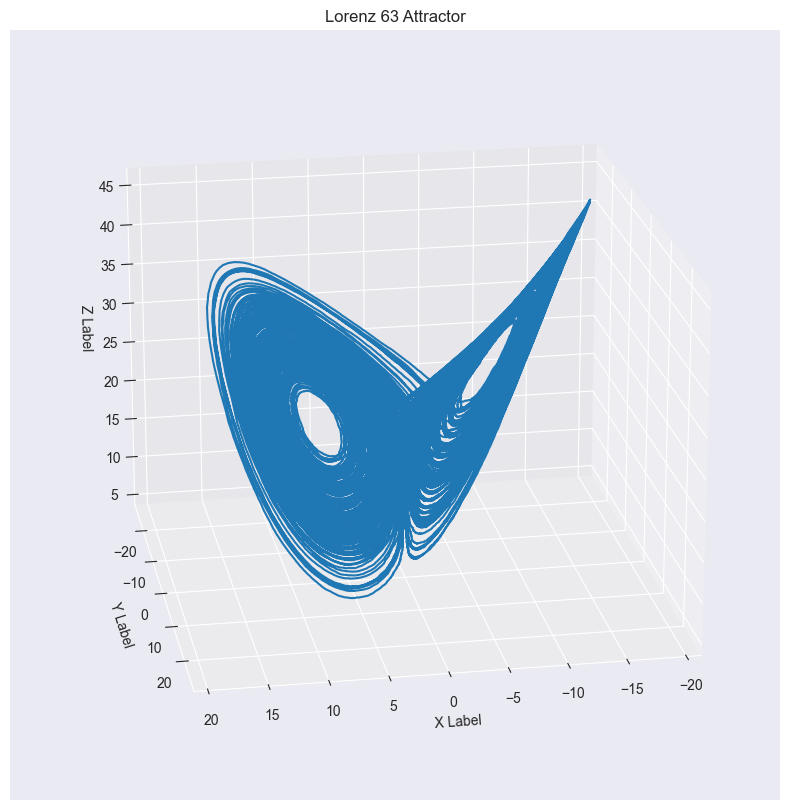

In [7]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.plot(x_coordinates,  y_coordinates, z_coordinates)

# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('Lorenz 63 Attractor')
ax.view_init(20, 80)


# set labels
plt.show()

### Save only each dt_out sample as reference trajectory
Saving only the data at each time step dt_out instead of dt. that means that only each 50th step is saved for the
reference trajectory


In [9]:
step_size: int = int(dt_out/dt)
x_ref_trajectory: list = []
for t_out in range(0, len(x_coordinates), step_size):
    x_ref_trajectory.append(x_coordinates[t_out])

# save as csv / transform int into a dataframe with one column and each row is one x_coordinate
df_ref_trajectory = pd.DataFrame(x_ref_trajectory).transpose()
print(df_ref_trajectory.shape)
df_ref_trajectory.to_csv("Reference_Trajectory_0.05.csv",index=False, header=False)

(1, 4001)


# Task 1.2
We have saved the reference trajectory using $\delta t_{out}=0.05$, since we want the frequency of the observations to be smaller (i.e measurement frequency is smaller than the one used to produce the surrogate model ($z_{ref}$)): we get an observation every $\delta t_{out}$. <br>
We get observations this way:
$y_{obs}(t)=h(z_{ref}(t))+ \sum_{i=0}^I \eta_i(t)$, where the $\eta_is$ represent the measurement errors. In this exercise we observe only the $x$- component, then we have $h(z_{ref}(t))=<(1,0,0),z_{ref}(t)>=x_{ref}(t)$.
Furthermore to generate the measurement errors we use a different implementation of the tent map (different $a$) with respect to the previous one.
In this exercise we generate $N_{obs}=4000$ observations (up to time 200).

In [52]:
def modified_tent_map(iters: int, a: float = 4.0, tmp_factor: float = 1.999999):
    """
    Calculate the modified tent_map. Since only x_coordinates are considered, y, z are not present in the
    implementation
    :param iters: How many iterations of the tent map should be run
    :param tmp_factor: Factor that is used for the tent_map boundaries.
    :param a: 4
    :return:
    """
    csi = list(np.zeros((iters,)))
    csi[0] = a * (1 / np.sqrt(2) - 1 / 2)

    for index in range(iters - 1):
        csi_old: float = csi[index]
        csi[index + 1] = tmp_factor * (csi_old + 1) if 0 > csi_old >= -2 else -tmp_factor * (csi_old - 1)

    return csi


def measurement_error(num_obs: int, tent_map_type: int):
    """
    Function to generate the measurement errors using the modified tent_map
    :param num_obs: the number of observations that will be produced. For each observation, 20 measurements errors will be produced
    :param tent_map_type: either 1 or 2, if 1, the value of 1.99999/-1999999 will be used to produce the tent map if type 2 the value 2 is used instead.
    :return:
    """
    num_errors: int = int(200 * num_obs + 1)
    tmp_factor: float = 2 if tent_map_type == 2 else 1.9999999
    csi_cap: np.array = np.zeros((20 * num_obs + 1,))  # for each observation we consider 20 components of Csi.

    csi: list = modified_tent_map(iters=num_errors, tmp_factor=tmp_factor)

    # take only each 10th measurement error that was produced
    for i in range(1, csi_cap.shape[0]):
        csi_cap[i] = csi[10 * i]

    return csi_cap


def generate_observations(ref_trajectory: list, tent_map_type: int):
    """Function to generate observations with measurement errors implemented above.
       I assume that we want to generate observations for the first component, as required in the exercise.
       If tent_map_type==1 csi_1 is called, otherwise csi_2 is called"""
    num_obs: int = len(ref_trajectory)
    x_obs=np.zeros((num_obs,))
    measurement_errors=np.zeros((num_obs,))

    csi = measurement_error(num_obs=num_obs, tent_map_type=tent_map_type)
    x_obs[0]=ref_trajectory[0]

    ind1 = ind2 = 1
    for k in range(1, num_obs):
        ind2 = ind1 + 20
        measurement_errors[k] = 1/20 * sum(csi[ind1:ind2])
        x_obs[k] = ref_trajectory[k] + measurement_errors[k]
        ind1 += 20

    return x_obs, measurement_errors

x_obs_1, m_errors1 = generate_observations(x_ref_trajectory,1) #first version of the tent map
x_obs_2, m_errors2 = generate_observations(x_ref_trajectory,2) #second version of the tent map

## Generate Observations

## Plot results

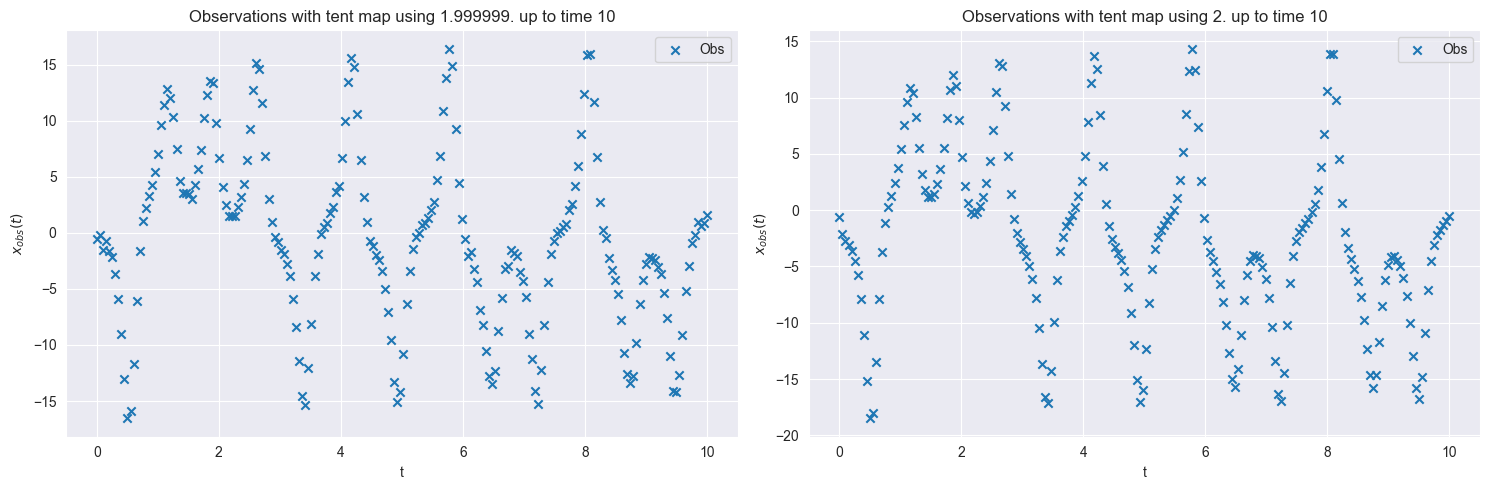

In [53]:
x=np.linspace(0,10,200)
time=10
fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(x,x_obs_1[:int(time/dt_out)], marker='x', label='Obs')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('$x_{obs}(t)$')
ax[0].set_title('Observations with tent map using 1.999999. up to time 10')
ax[1].scatter(x,x_obs_2[:int(time/dt_out)], marker='x', label='Obs')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$x_{obs}(t)$')
ax[1].set_title('Observations with tent map using 2. up to time 10')
fig.tight_layout()
#we see that there is a slight difference

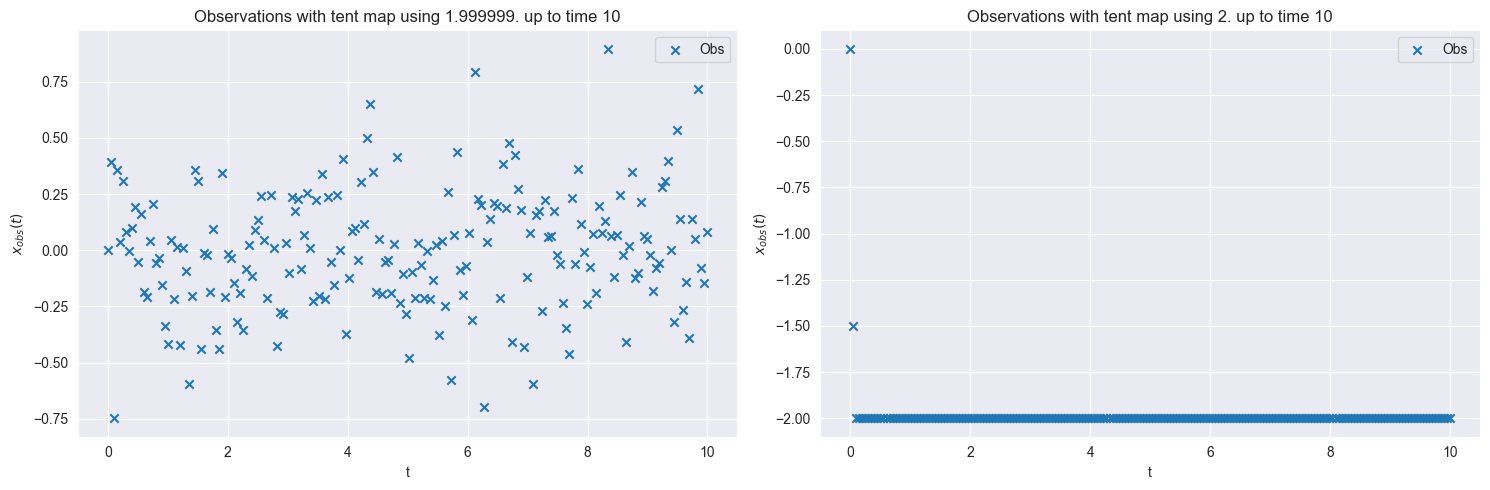

In [54]:
x=np.linspace(0,10,200)
time=10
fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(x,m_errors1[:int(time/dt_out)], marker='x', label='Obs')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('$x_{obs}(t)$')
ax[0].set_title('Observations with tent map using 1.999999. up to time 10')
ax[1].scatter(x,m_errors2[:int(time/dt_out)], marker='x', label='Obs')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$x_{obs}(t)$')
ax[1].set_title('Observations with tent map using 2. up to time 10')
fig.tight_layout()

we observe that when we use 2.0 instead of 1.9999999 for the tent_map, the error will crash and stay always -2

# Task 1.3
1.3 Making predictions. We set $t_{k_*}=100$ and make 2000 predictions until time $t=200$, which means that we start from $k=2000$ and stop at $k=4000$

For linear extrapolation we just need the two observations before the one we want to predict

If we are at time $t_{k_*}$ and we want to predict $x_{obs}(t_{k_*+1})$ we can fit a polynomial of degree 1 (i.e a line) passing through $x_{obs}(t_{k_*-1})$ and $x_{obs}(t_{k_*})$, which then is:<br>
$p(t)=x_{obs}(t_{k_*-1})+(t-t_{k_*})\frac{x_{obs}(t_{k_*})-x_{obs}(t_{k_*-1})}{\delta t_{out}}$, <br>
then since $\delta t_{out}=x_{obs}(t_{k_*})-x_{obs}(t_{k_*-1})=x_{obs}(t_{k_*+1})-x_{obs}(t_{k_*})$, we get the linear extrapolation formula: <br>
$x_p(t_{k_*+1})=p(t_{k_*+1})=2x_{obs}(t_{k_*})-x_{obs}(t_{k_*-1})$



In [55]:
def squared_absolute_error(x_ob: float, x_pred: float):
    """
    Calculate the Squared Absolute Error
    :param x_ob: the actual observation
    :param x_pred: the prediction
    :return: abs(x_ob-x_pred)**2
    """
    return abs(x_ob-x_pred)**2


def make_prediction(x_ob1: float, x_ob2: float):
    """
    Make a prediction based on two observations
    :param x_ob1: first observation
    :param x_ob2: second observation
    :return:
    """
    return 2 * x_ob2 - x_ob1

def rmse(abs_errors: np.array):
    """
    Mean Roo Squared Error
    :param abs_errors: A vector of absolute Errors
    :return: np.sqrt(abs_errors.mean())
    """
    return np.sqrt(abs_errors.mean())

abs_errors = np.zeros((2000,))
predictions = np.zeros((2000,))

for i in range(2001,4001):
    predictions[i-2001] = make_prediction(x_obs_2[i-2],x_obs_2[i-1])
    abs_errors[i-2001] = squared_absolute_error(x_obs_2[i],predictions[i-2001])
rmse = rmse(abs_errors)
print("Mean squared error: %r" %rmse)

Mean squared error: 1.1840567445315238


Text(0, 0.5, '$x$-component')

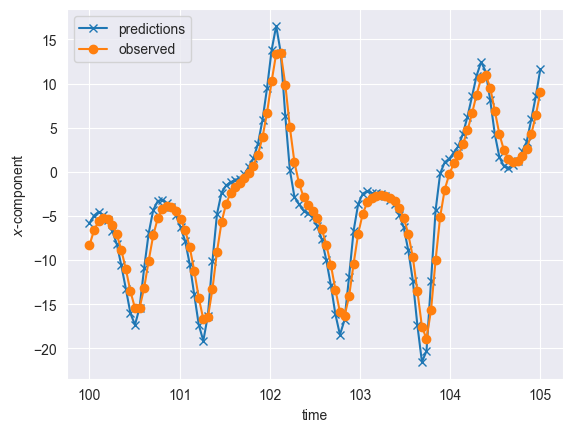

In [56]:
fig1,ax1=plt.subplots()
x1=np.linspace(100,105,100)
ax1.plot(x1,predictions[:100], label='predictions', marker='x')
ax1.plot(x1,x_obs_2[2000:2100], label='observed', marker='o')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('$x$-component')